In [ ]:
#Drive access

from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

!cp "/content/drive/My Drive/.../utils1.py" .

save = False


In [2]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from utils1 import make_classification_adjusted
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

DATASET GENERATION

In [3]:
#Function to create plots
def create_plot(df_pl, colors = {0:'#4169e1', 1:'#a50a27'}, title='', group_by='label', savefile='', xlim=[-5, 4], ylim=[-5, 5], figsize=(10,5)):
  fig, ax = pyplot.subplots(figsize=figsize)

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.2)
  grouped = df_pl.groupby(group_by)
  for key, group in grouped:
        # Calculate a darker shade of the interior color
        interior_color = colors[key]
        interior_rgb = tuple(int(interior_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        dark_rgb = tuple(max(0, c - 51) for c in interior_rgb)
        dark_color = '#{:02x}{:02x}{:02x}'.format(*dark_rgb)

        group.plot(
            ax=ax, kind='scatter', x='x', y='y',
            label=group_by + '_' + str(key), color=interior_color, edgecolor=dark_color, alpha=0.5
        )
  pyplot.title(title, pad=15, fontsize=20)
  pyplot.xticks(**{'fontsize':12})
  pyplot.yticks(**{'fontsize':12})
  pyplot.xlabel('x1', **{'fontsize':16})
  pyplot.ylabel('x2', **{'fontsize':16})
  pyplot.grid(color = '#aebcc6', linestyle = '--', linewidth = 0.3)
  axes = pyplot.gca()
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  pyplot.legend( **{'fontsize':18})
  pyplot.show()

In [4]:
# Generate a simulated datasets with two classes
n_samples = 6000
n_classes = 2
n_features = 2
n_informative = 2
n_redundant = 0
class_sep = 0.7
n_clusters_per_class=1

X, y, clusters = make_classification_adjusted(n_samples=n_samples,
                                              n_classes=n_classes,
                                              n_features=n_features,
                                              n_informative=n_informative,
                                              n_redundant=0, hypercube=True,
                                              random_state=1,
                                              class_sep=class_sep,
                                              n_clusters_per_class=n_clusters_per_class,
                                              weights=np.array([0.8, 0.2]),
                                              shuffle=False)

class_num = Counter(y)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y, clusters=clusters))

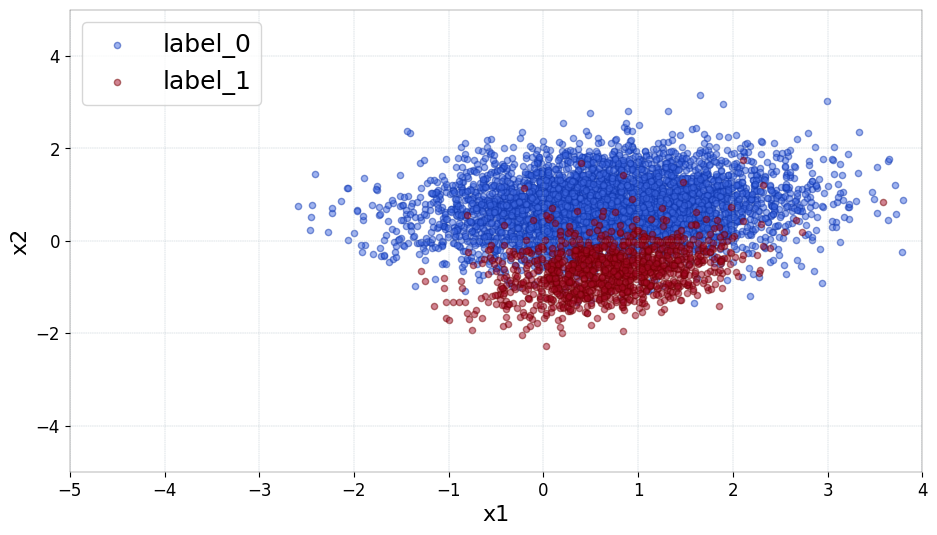

In [5]:
create_plot(df, title='', figsize=(11,6))

In [6]:
np.random.seed(1)
df2 = df[df['clusters']==2].copy()
df2['x'] = df2['x']-3
df2['y'] = df2['y'] + np.random.randn(df2.shape[0])
df2['clusters'] = 3
df2.head()

df = pd.concat((df, df2))

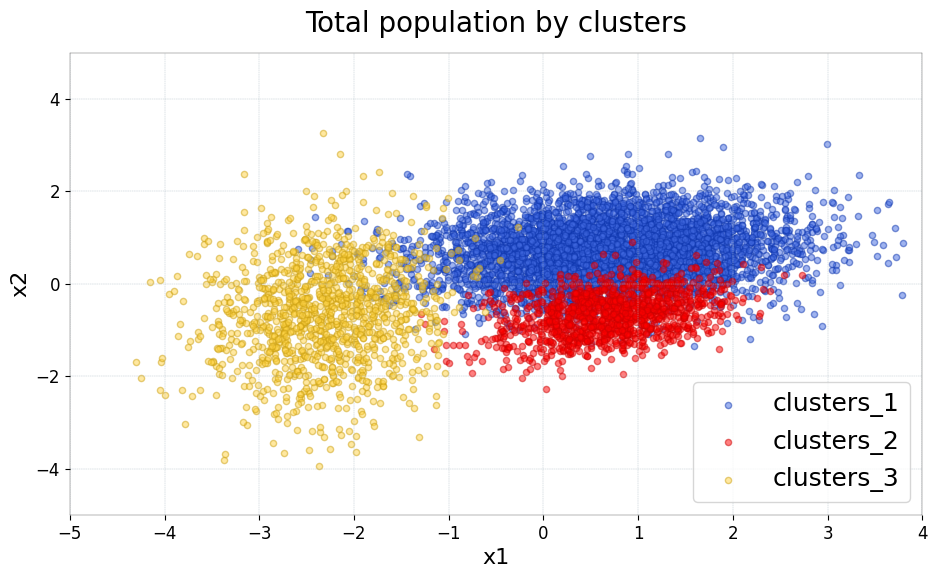

In [7]:
create_plot(df, title='Total population by clusters', group_by='clusters',
            colors={1: '#4169e1', 2: '#FF0000', 3: '#ffd343', 4: '#0000FF'},
            ylim=[-5, 5], figsize=(11,6))

In [8]:
#"Hiding" cluster 3
iCl2 = np.where(df['clusters'] == 3)
iCl134 = np.where(df['clusters'] != 3)

In [9]:
np.random.seed(1)
rsize = round(Counter(y[iCl134])[1]*0.5)
bsize = rsize
iRedTrain = np.random.choice(np.where(y[iCl134]==1)[0], size=rsize, replace=False)
iBlueTrain = np.random.choice(np.where(y[iCl134]==0)[0], size=bsize, replace=False)

X = df[['x', 'y']].to_numpy()
y = df['label'].to_numpy()
y_cluster = df['clusters'].to_numpy()

X_bal = X[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
y_bal = y[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
X_test = np.concatenate((X[iCl2], X[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))
y_test = np.concatenate((y[iCl2], y[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))
X_test_ood = X[iCl2]
y_test_ood = y[iCl2]

In [10]:
# Stratified selection for training and val
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(X_bal,
                                                                  y_bal,
                                                                  stratify=y_bal,
                                                                  random_state=1,
                                                                  test_size=0.3)

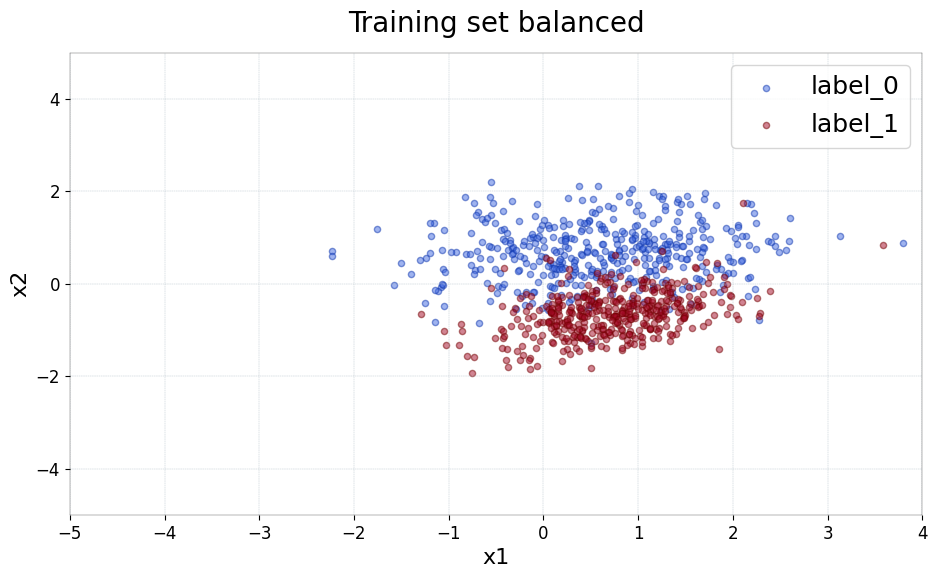

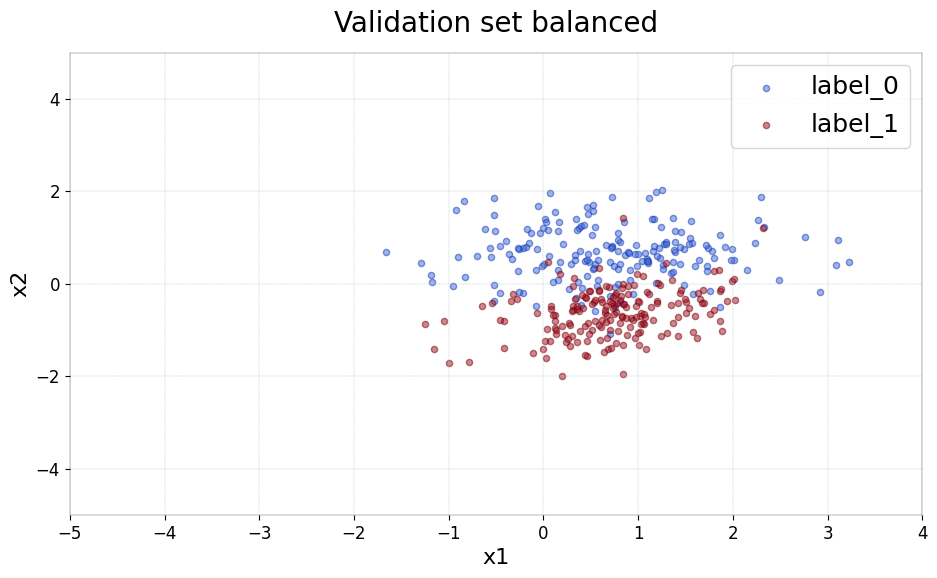

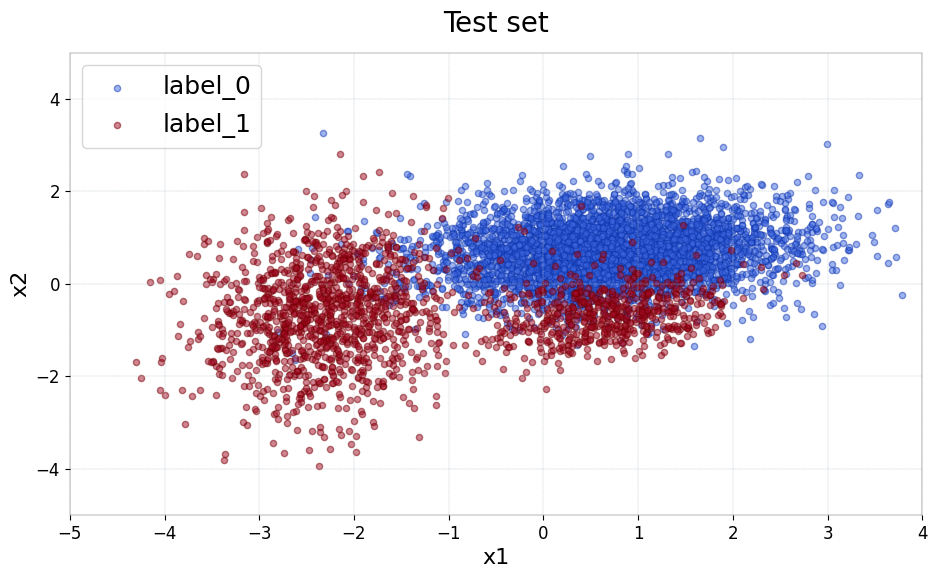

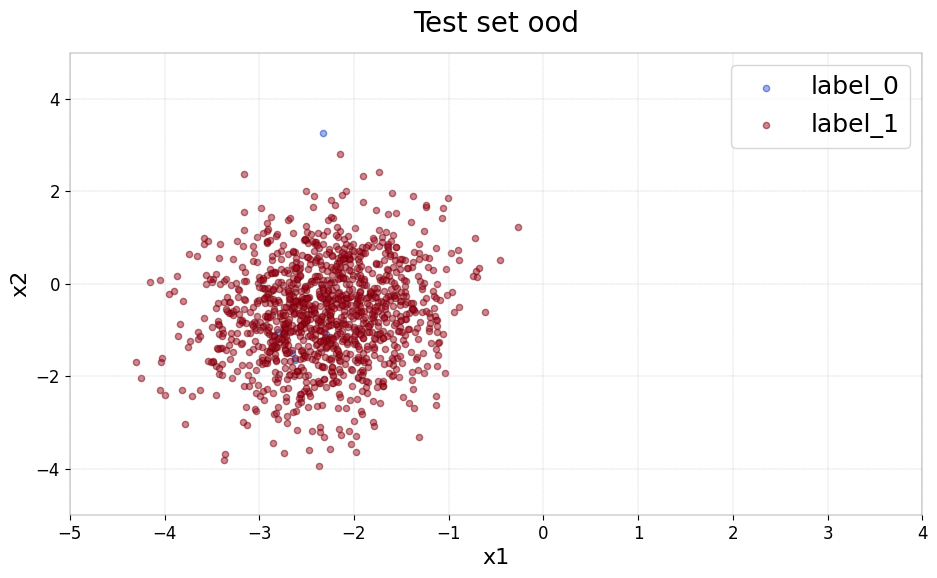

In [11]:
create_plot(pd.DataFrame(dict(x=X_train_bal[:, 0],
                              y=X_train_bal[:, 1], label=y_train_bal)),
            title='Training set balanced', figsize=(11,6))
create_plot(pd.DataFrame(dict(x=X_val_bal[:, 0],
                              y=X_val_bal[:, 1], label=y_val_bal)),
            title='Validation set balanced', figsize=(11,6))
create_plot(pd.DataFrame(dict(x=X_test[:, 0],
                              y=X_test[:, 1], label=y_test)),
            title='Test set', figsize=(11,6))
create_plot(pd.DataFrame(dict(x=X_test_ood[:, 0],
                              y=X_test_ood[:, 1], label=y_test_ood)),
            title='Test set ood', figsize=(11,6))

In [12]:
c_training = Counter(y_train_bal)
c_test = Counter(y_test)
c_val = Counter(y_val_bal)

print('*****Training set*****\nNumber of examples in class 0:', c_training[0],
      '\nNumber of examples in class 1', c_training[1])
print('*****Validation set*****\nNumber of examples in class 0:', c_val[0],
      '\nNumber of examples in class 1', c_val[1])
print('*****Test set*****\nNumber of examples in class 0:', c_test[0],
      '\nNumber of examples in class 1', c_test[1])

*****Training set*****
Number of examples in class 0: 428 
Number of examples in class 1 428
*****Validation set*****
Number of examples in class 0: 184 
Number of examples in class 1 184
*****Test set*****
Number of examples in class 0: 4168 
Number of examples in class 1 1808


TRAINING OF THE CLASSIFIER

In [13]:
# Training
clf = RandomForestClassifier(random_state=1, min_samples_leaf=10,
                             n_estimators=100)

clf.fit(X_train_bal, y_train_bal)

# Prediction on the test set
ypred_test = clf.predict(X_test)
ypred_proba_test = clf.predict_proba(X_test)

# Prediction on the validation set
ypred_val = clf.predict(X_val_bal)
ypred_proba_val = clf.predict_proba(X_val_bal)

# Prediction on the training set
ypred_train = clf.predict(X_train_bal)
ypred_proba_train = clf.predict_proba(X_train_bal)

RELIABILITY ASSESSMENT

RelAI

In [14]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [15]:
from ReliabilityPackage.ReliabilityFunctions import *

Build an Autoencoder on the Training Set

EPOCH 1
EPOCH 2
...
EPOCH 999
EPOCH 1000


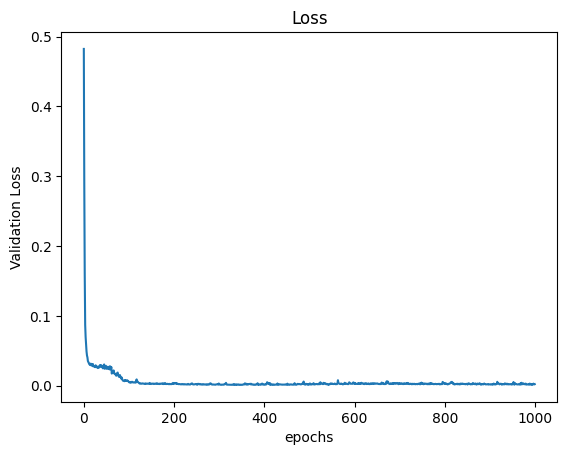

In [16]:
ae = create_and_train_autoencoder(X_train_bal, X_val_bal, batchsize=80, layer_sizes = [2, 4, 20], epochs=1000, optimizer_params = {'lr': 0.01, 'weight_decay': 1e-8})

Generate the Dataset of the synthetic points and compute their associated accuracies

In [17]:
syn_pts, acc_syn_pts = generate_synthetic_points(problem_type='classification', predict_func=clf.predict, X_train=X_train_bal, y_train=y_train_bal, method="GN", k = 5)

Grid Search for hyperparameters tuning (MSE threshold and Accuracy threshold)

In [18]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef, average_precision_score, brier_score_loss

def compute_metrics(y, ypred):
  scores = []
  scores.append(balanced_accuracy_score(y, ypred))
  scores.append(precision_score(y, ypred))
  scores.append(recall_score(y, ypred))
  scores.append(roc_auc_score(y, ypred))
  scores.append(f1_score(y, ypred))
  scores.append(matthews_corrcoef(y, ypred))
  scores.append(average_precision_score(y, ypred))
  scores.append(brier_score_loss(y, ypred))

  return scores

In [19]:
#List of MSE thresholds and list of Accuracy thresholds used in the grid search for the parameters' tuning
mse_threshold_list = [perc_mse_threshold(ae, X_val_bal, perc=92),
                      perc_mse_threshold(ae, X_val_bal, perc=93),
                      perc_mse_threshold(ae, X_val_bal, perc=94),
                      perc_mse_threshold(ae, X_val_bal, perc=95),
                      perc_mse_threshold(ae, X_val_bal, perc=96),
                      perc_mse_threshold(ae, X_val_bal, perc=97),
                      perc_mse_threshold(ae, X_val_bal, perc=98),]

acc_threshold_list = [.75,.80,.85,.90,.95,.97]

In [20]:
#All the possible combination of the mse and accuracy's thresholds for the grid search
param = []
for i in range(len(mse_threshold_list)):
  for j in range(len(acc_threshold_list)):
    param.append([mse_threshold_list[i],acc_threshold_list[j]])

In [21]:
#Computing the performance scores for each parameters' combination
grid_search_scores_val = []

for z in range(len(param)):
  print("Set",z,"/",(len(param)-1))

  RD = create_reliability_detector('classification', ae, syn_pts, acc_syn_pts, mse_thresh=param[z][0], perf_thresh=param[z][1], proxy_model="MLP")

  val_reliability = compute_dataset_reliability(RD, X_val_bal, mode='total')
  reliable_val = X_val_bal[np.where(val_reliability == 1)]
  y_reliable_val = y_val_bal[np.where(val_reliability == 1)]
  ypred_reliable_val = clf.predict(reliable_val)
  unreliable_val = X_val_bal[np.where(val_reliability == 0)]
  y_unreliable_val = y_val_bal[np.where(val_reliability == 0)]
  ypred_unreliable_val = clf.predict(unreliable_val)

  grid_search_scores_val.append([compute_metrics(y_val_bal, ypred_val),compute_metrics(y_reliable_val, ypred_reliable_val),compute_metrics(y_unreliable_val, ypred_unreliable_val)])

Set 0 / 41
Set 1 / 41
Set 2 / 41
Set 3 / 41
Set 4 / 41
Set 5 / 41
Set 6 / 41
Set 7 / 41
Set 8 / 41
Set 9 / 41
Set 10 / 41
Set 11 / 41
Set 12 / 41
Set 13 / 41
Set 14 / 41
Set 15 / 41
Set 16 / 41
Set 17 / 41
Set 18 / 41
Set 19 / 41
Set 20 / 41
Set 21 / 41
Set 22 / 41
Set 23 / 41
Set 24 / 41
Set 25 / 41
Set 26 / 41
Set 27 / 41
Set 28 / 41
Set 29 / 41
Set 30 / 41
Set 31 / 41
Set 32 / 41
Set 33 / 41
Set 34 / 41
Set 35 / 41
Set 36 / 41
Set 37 / 41
Set 38 / 41
Set 39 / 41
Set 40 / 41
Set 41 / 41


In [22]:
#Distinguish between the performance scores of the Validation set (all_scores) and of the reliable (rel_scores) and unreliable (unrel_scores) subsets.
all_scores = []
rel_scores= []
unrel_scores = []

for j in np.arange(8):
  for i in range(len(param)):
    all_scores.append(grid_search_scores_val[i][0][j])
    rel_scores.append(grid_search_scores_val[i][1][j])
    unrel_scores.append(grid_search_scores_val[i][2][j])

In [23]:
#Devide the reliable and unreliable scores based on the performance metric
metr_rel_scores = []
metr_unrel_scores = []
for i in range(8):
  metr_rel_scores.append(rel_scores[i*len(param):(i+1)*len(param)])
  metr_unrel_scores.append(unrel_scores[i*len(param):(i+1)*len(param)])

In [24]:
from numpy.core.fromnumeric import argmin, argmax
from statistics import mode

#Max offset between reliable and unreliable for each score, conditioned to maximum reliable performance.
max_deltas = []
for i in range(len(metr_rel_scores)):
  delta = []
  max_rel_ix = []
  for j in range(len(metr_rel_scores[i])):
    if i != 7:
      if metr_rel_scores[i][j] == max(metr_rel_scores[i]):
        max_rel_ix.append(j)
    elif i == 7:
      if metr_rel_scores[i][j] == min(metr_rel_scores[i]):
        max_rel_ix.append(j)
    delta.append(abs(metr_unrel_scores[i][j]-metr_rel_scores[i][j]))
  selected_deltas = np.take(delta, max_rel_ix)
  max_deltas.append(max_rel_ix[argmax(selected_deltas)])
print(max_deltas)
#Choose the parameters' combination as the most frequent optimum for each metric.
selected_param = mode(max_deltas)

[38, 26, 26, 38, 26, 38, 26, 38]


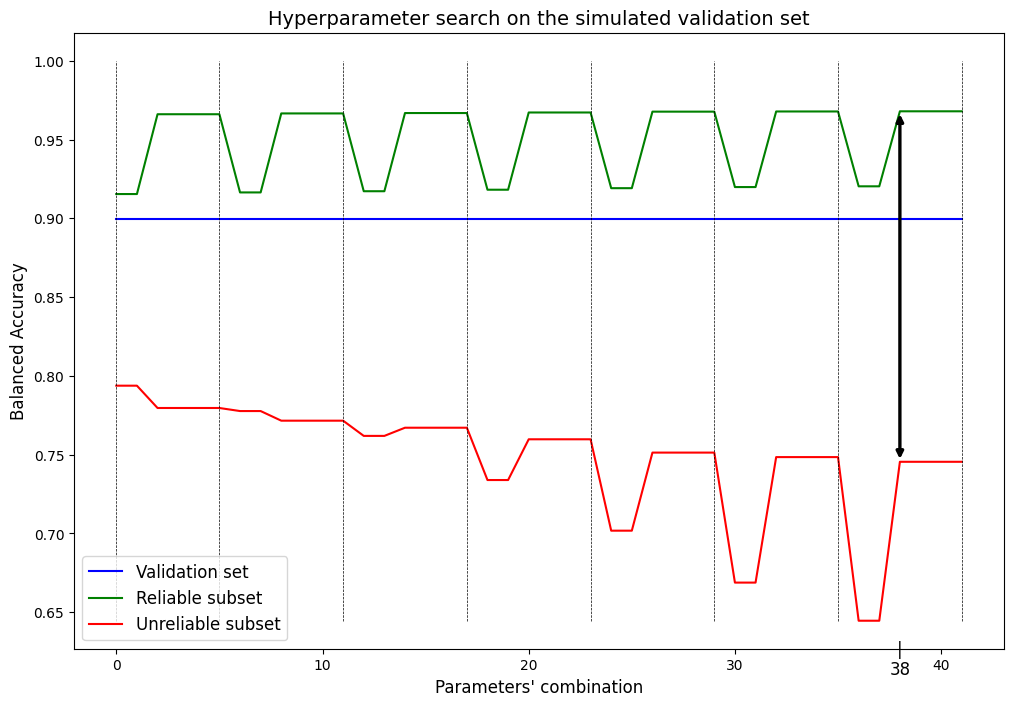

In [25]:
from matplotlib.patches import Circle
#Plots of the scores for each parameters' combination
vlines_pos = [i-1 for i in range(0, len(param)+1) if (i % len(acc_threshold_list) == 0) & (i != 0)]
vlines_pos.insert(0,0)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(len(param)),all_scores[0:1*len(param)], color = 'b', label = 'Validation set')
ax.plot(np.arange(len(param)),rel_scores[0:1*len(param)], color = 'g', label = 'Reliable subset')
ax.plot(np.arange(len(param)),unrel_scores[0:1*len(param)], color = 'r', label = 'Unreliable subset')
ax.vlines(vlines_pos, min(unrel_scores[0:1*len(param)]+rel_scores[0:1*len(param)]+all_scores[0:1*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax.text(selected_param, ax.get_ylim()[0]+0.0055, "|\n"+str(selected_param), verticalalignment='top', horizontalalignment='center', color='black', fontsize="large", fontweight=500)
ax.annotate("", xy=(selected_param, max(unrel_scores[0:1*len(param)]+rel_scores[0:1*len(param)]+all_scores[0:1*len(param)])), xytext=(selected_param, unrel_scores[selected_param]),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='<|-|>', lw=2.4))
ax.set_title("Hyperparameter search on the simulated validation set", fontsize=14)
ax.set_xlabel("Parameters' combination", fontsize=12)
ax.set_ylabel("Balanced Accuracy", fontsize=12)
ax.legend(loc = 'lower left', fontsize = 12)

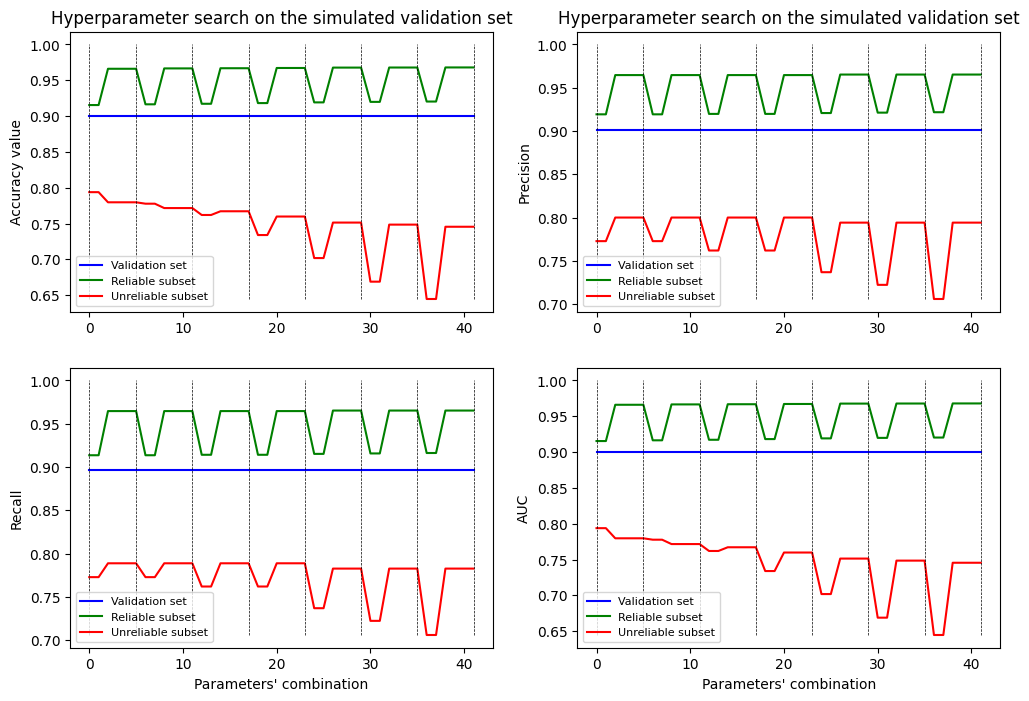

In [26]:
#Plots of Balanced Accuracy, Precision, Recall and AUC for each parameters' combination
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
ax[0][0].plot(np.arange(len(param)),all_scores[0:1*len(param)], color = 'b', label = 'Validation set')
ax[0][0].plot(np.arange(len(param)),rel_scores[0:1*len(param)], color = 'g', label = 'Reliable subset')
ax[0][0].plot(np.arange(len(param)),unrel_scores[0:1*len(param)], color = 'r', label = 'Unreliable subset')
ax[0][0].vlines(vlines_pos, min(unrel_scores[0:1*len(param)]+rel_scores[0:1*len(param)]+all_scores[0:1*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[0][0].set_title("Hyperparameter search on the simulated validation set")
ax[0][0].set_ylabel("Accuracy value")
ax[0][0].legend(loc = 'lower left', fontsize = 8)

ax[0][1].plot(np.arange(len(param)),all_scores[1*len(param):2*len(param)], color = 'b', label = 'Validation set')
ax[0][1].plot(np.arange(len(param)),rel_scores[1*len(param):2*len(param)], color = 'g', label = 'Reliable subset')
ax[0][1].plot(np.arange(len(param)),unrel_scores[1*len(param):2*len(param)], color = 'r', label = 'Unreliable subset')
ax[0][1].vlines(vlines_pos, min(unrel_scores[1*len(param):2*len(param)]+rel_scores[1*len(param):2*len(param)]+all_scores[1*len(param):2*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[0][1].set_title("Hyperparameter search on the simulated validation set")
ax[0][1].set_ylabel("Precision")
ax[0][1].legend(loc = 'lower left', fontsize = 8)

ax[1][0].plot(np.arange(len(param)),all_scores[2*len(param):3*len(param)], color = 'b', label = 'Validation set')
ax[1][0].plot(np.arange(len(param)),rel_scores[2*len(param):3*len(param)], color = 'g', label = 'Reliable subset')
ax[1][0].plot(np.arange(len(param)),unrel_scores[2*len(param):3*len(param)], color = 'r', label = 'Unreliable subset')
ax[1][0].vlines(vlines_pos, min(unrel_scores[2*len(param):3*len(param)]+rel_scores[2*len(param):3*len(param)]+all_scores[2*len(param):3*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[1][0].set_title("")
ax[1][0].set_xlabel("Parameters' combination")
ax[1][0].set_ylabel("Recall")
ax[1][0].legend(loc = 'lower left', fontsize = 8)

ax[1][1].plot(np.arange(len(param)),all_scores[3*len(param):4*len(param)], color = 'b', label = 'Validation set')
ax[1][1].plot(np.arange(len(param)),rel_scores[3*len(param):4*len(param)], color = 'g', label = 'Reliable subset')
ax[1][1].plot(np.arange(len(param)),unrel_scores[3*len(param):4*len(param)], color = 'r', label = 'Unreliable subset')
ax[1][1].vlines(vlines_pos, min(unrel_scores[3*len(param):4*len(param)]+rel_scores[3*len(param):4*len(param)]+all_scores[3*len(param):4*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[1][1].set_title("")
ax[1][1].set_xlabel("Parameters' combination")
ax[1][1].set_ylabel("AUC")
ax[1][1].legend(loc = 'lower left', fontsize = 8)


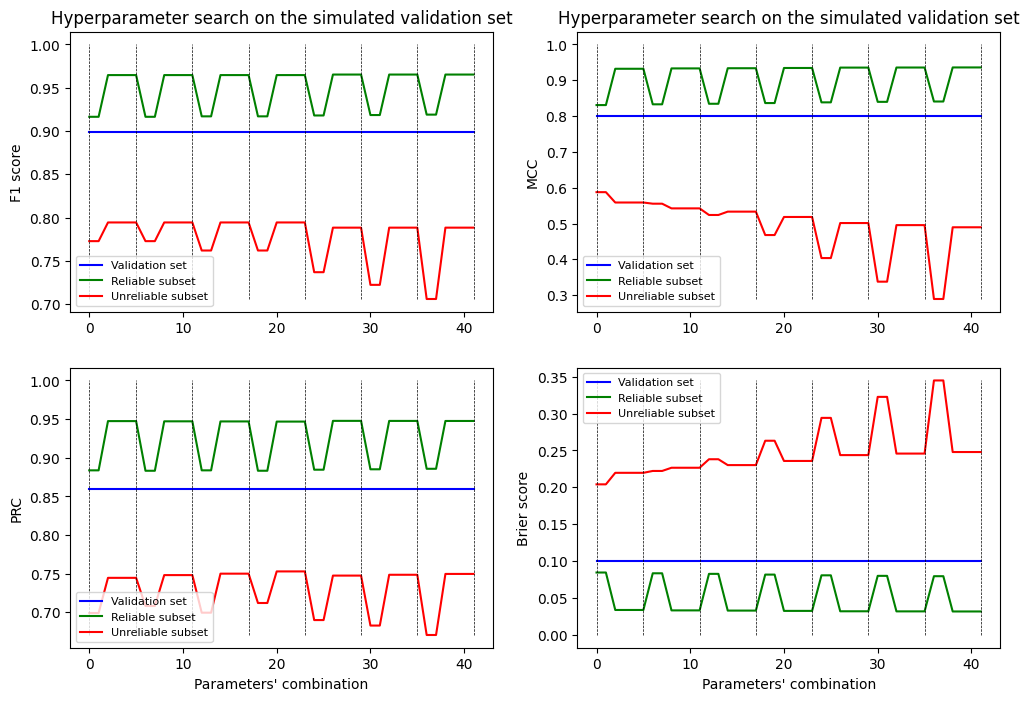

In [27]:
#Plots of F1 score, MCC, PRC and Brier score for each parameters' combination
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
ax[0][0].plot(np.arange(len(param)),all_scores[4*len(param):5*len(param)], color = 'b', label = 'Validation set')
ax[0][0].plot(np.arange(len(param)),rel_scores[4*len(param):5*len(param)], color = 'g', label = 'Reliable subset')
ax[0][0].plot(np.arange(len(param)),unrel_scores[4*len(param):5*len(param)], color = 'r', label = 'Unreliable subset')
ax[0][0].vlines(vlines_pos, min(unrel_scores[4*len(param):5*len(param)]+rel_scores[4*len(param):5*len(param)]+all_scores[4*len(param):5*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[0][0].set_title("Hyperparameter search on the simulated validation set")
ax[0][0].set_ylabel("F1 score")
ax[0][0].legend(loc = 'lower left', fontsize = 8)

ax[0][1].plot(np.arange(len(param)),all_scores[5*len(param):6*len(param)], color = 'b', label = 'Validation set')
ax[0][1].plot(np.arange(len(param)),rel_scores[5*len(param):6*len(param)], color = 'g', label = 'Reliable subset')
ax[0][1].plot(np.arange(len(param)),unrel_scores[5*len(param):6*len(param)], color = 'r', label = 'Unreliable subset')
ax[0][1].vlines(vlines_pos, min(unrel_scores[5*len(param):6*len(param)]+rel_scores[5*len(param):6*len(param)]+all_scores[5*len(param):6*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[0][1].set_title("Hyperparameter search on the simulated validation set")
ax[0][1].set_ylabel("MCC")
ax[0][1].legend(loc = 'lower left', fontsize = 8)

ax[1][0].plot(np.arange(len(param)),all_scores[6*len(param):7*len(param)], color = 'b', label = 'Validation set')
ax[1][0].plot(np.arange(len(param)),rel_scores[6*len(param):7*len(param)], color = 'g', label = 'Reliable subset')
ax[1][0].plot(np.arange(len(param)),unrel_scores[6*len(param):7*len(param)], color = 'r', label = 'Unreliable subset')
ax[1][0].vlines(vlines_pos, min(unrel_scores[6*len(param):7*len(param)]+rel_scores[6*len(param):7*len(param)]+all_scores[6*len(param):7*len(param)]), 1, linestyles='dashed', colors='black', lw = 0.5)
ax[1][0].set_title("")
ax[1][0].set_xlabel("Parameters' combination")
ax[1][0].set_ylabel("PRC")
ax[1][0].legend(loc = 'lower left', fontsize = 8)

ax[1][1].plot(np.arange(len(param)),all_scores[7*len(param):8*len(param)], color = 'b', label = 'Validation set')
ax[1][1].plot(np.arange(len(param)),rel_scores[7*len(param):8*len(param)], color = 'g', label = 'Reliable subset')
ax[1][1].plot(np.arange(len(param)),unrel_scores[7*len(param):8*len(param)], color = 'r', label = 'Unreliable subset')
ax[1][1].vlines(vlines_pos, 0, max(unrel_scores[7*len(param):8*len(param)]+rel_scores[7*len(param):8*len(param)]+all_scores[7*len(param):8*len(param)]), linestyles='dashed', colors='black', lw = 0.5)
ax[1][1].set_title("")
ax[1][1].set_xlabel("Parameters' combination")
ax[1][1].set_ylabel("Brier score")
ax[1][1].legend(loc = 'upper left', fontsize = 8)

In [28]:
print("Selected param combination:\n[MSE threshold, Accuracy threshold]\n", param[selected_param])

Selected param combination:
[MSE threshold, Accuracy threshold]
 [0.0064453272893628, 0.85]


Fix the MSE and Accuracy thresholds

In [30]:
mse_thresh = perc_mse_threshold(ae, X_val_bal, perc=98)
acc_thresh = 0.85

Generate an instance of the Reliability Detector Class (class-object able to evaluate the pointwise reliability of instances)

In [31]:
RD = create_reliability_detector('classification', ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")

Evaluate the reliability of the Training, Validation, and Test sets

In [32]:
train_reliability = compute_dataset_reliability(RD, X_train_bal, mode='total')
reliable_train = X_train_bal[np.where(train_reliability == 1)]
y_reliable_train = y_train_bal[np.where(train_reliability == 1)]
ypred_reliable_train = clf.predict(reliable_train)
unreliable_train = X_train_bal[np.where(train_reliability == 0)]
y_unreliable_train = y_train_bal[np.where(train_reliability == 0)]
ypred_unreliable_train = clf.predict(unreliable_train)

val_reliability = compute_dataset_reliability(RD, X_val_bal, mode='total')
reliable_val = X_val_bal[np.where(val_reliability == 1)]
y_reliable_val = y_val_bal[np.where(val_reliability == 1)]
ypred_reliable_val = clf.predict(reliable_val)
unreliable_val = X_val_bal[np.where(val_reliability == 0)]
y_unreliable_val = y_val_bal[np.where(val_reliability == 0)]
ypred_unreliable_val = clf.predict(unreliable_val)

test_reliability = compute_dataset_reliability(RD, X_test, mode='total')
reliable_test = X_test[np.where(test_reliability == 1)]
y_reliable_test = y_test[np.where(test_reliability == 1)]
ypred_reliable_test = clf.predict(reliable_test)
unreliable_test = X_test[np.where(test_reliability == 0)]
y_unreliable_test = y_test[np.where(test_reliability == 0)]
ypred_unreliable_test = clf.predict(unreliable_test)

test_ood_reliability = compute_dataset_reliability(RD, X_test_ood, mode='total')
reliable_test_ood = X_test_ood[np.where(test_ood_reliability == 1)]
y_reliable_test_ood = y_test_ood[np.where(test_ood_reliability == 1)]
ypred_reliable_test_ood = clf.predict(reliable_test_ood)
unreliable_test_ood = X_test_ood[np.where(test_ood_reliability == 0)]
y_unreliable_test_ood = y_test_ood[np.where(test_ood_reliability == 0)]
ypred_unreliable_test_ood = clf.predict(unreliable_test_ood)

In [33]:
print("Training set:")
print("Reliable:", reliable_train.shape[0], "(",reliable_train.shape[0]/train_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_train.shape[0], "(",unreliable_train.shape[0]/train_reliability.shape[0]*100,"%)")
print("\nValidation set:")
print("Reliable:", reliable_val.shape[0], "(",reliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_val.shape[0], "(",unreliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("\nTest set:")
print("Reliable:", reliable_test.shape[0], "(",reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_test.shape[0], "(",unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("\nTest set ood:")
print("Reliable:", reliable_test_ood.shape[0], "(",reliable_test_ood.shape[0]/test_ood_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_test_ood.shape[0], "(",unreliable_test_ood.shape[0]/test_ood_reliability.shape[0]*100,"%)")

Training set:
Reliable: 602 ( 70.32710280373831 %)
Unreliable: 254 ( 29.672897196261683 %)

Validation set:
Reliable: 251 ( 68.20652173913044 %)
Unreliable: 117 ( 31.793478260869566 %)

Test set:
Reliable: 3571 ( 59.75568942436412 %)
Unreliable: 2405 ( 40.24431057563588 %)

Test set ood:
Reliable: 169 ( 14.083333333333334 %)
Unreliable: 1031 ( 85.91666666666666 %)


In [68]:
#Function to plot the metrics' plots
def metrics_plots(y, ypred, rel_y, rel_ypred, unrel_y, unrel_ypred, name):
  fig, ax = plt.subplots(figsize=(19, 7))
  xbarplot = np.arange(8)
  y1barplot = compute_metrics(y, ypred)
  y2barplot = compute_metrics(rel_y, rel_ypred)
  y3barplot = compute_metrics(unrel_y, unrel_ypred)

  bar_width = 0.27

  b1 = ax.bar(xbarplot, y1barplot, width = bar_width, color='steelblue')
  b2 = ax.bar(xbarplot+bar_width, y2barplot, width = bar_width, color='lightgreen')
  b3 = ax.bar(xbarplot+2*(bar_width), y3barplot, width = bar_width, color='salmon')

  ax.set_xticks(xbarplot + 2*(bar_width) / 2)
  ax.set_xticklabels(['Balanced Accuracy', 'Precision','Recall', 'AUC', 'f1-score', 'MCC', 'PRC', 'Brier Score'], fontsize=14)
  ax.legend([name,"Reliable "+name, "Unreliable "+name], fontsize=11)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  # Add axis and chart labels.
  ax.set_title('Classifier performances on the '+name, pad=15, fontsize=18)

  for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = round(bar.get_height(),3)
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = 'black'
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)

  # Set the fontsize for y-axis bar values
  ax.yaxis.set_tick_params(labelsize=10)
  #fig.tight_layout()

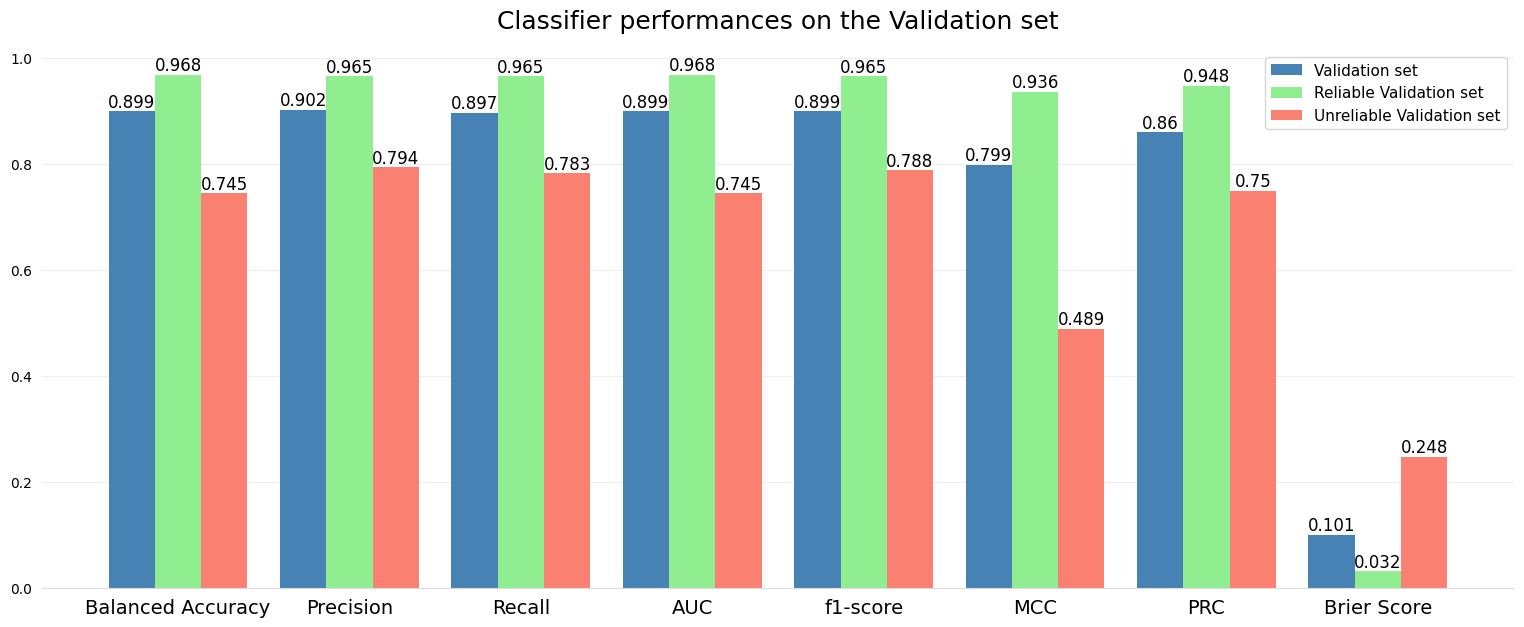

In [69]:
metrics_plots(y_val_bal, ypred_val, y_reliable_val, ypred_reliable_val, y_unreliable_val, ypred_unreliable_val,'Validation set')

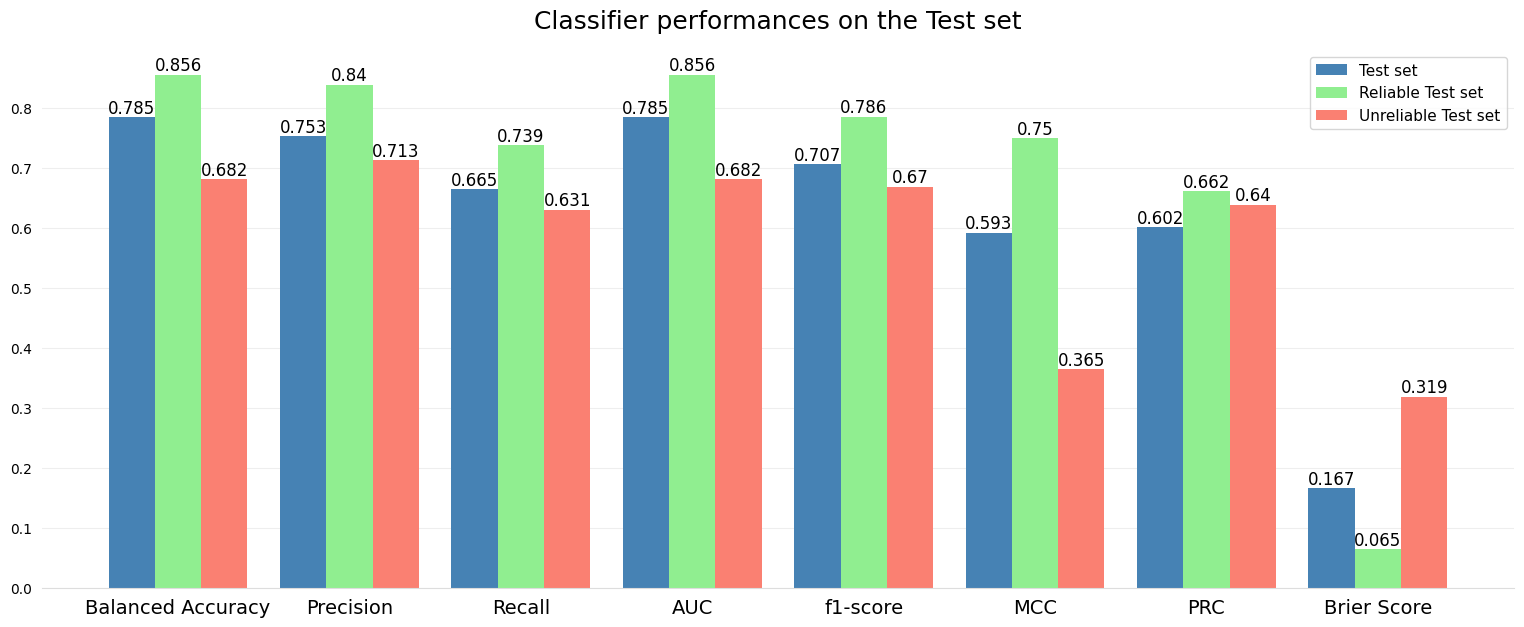

In [70]:
metrics_plots(y_test, ypred_test, y_reliable_test, ypred_reliable_test, y_unreliable_test, ypred_unreliable_test,'Test set')

DataFrame containing the labelled reliable/unreliable instances of the Test set

In [37]:
p_df_test_rel = pd.DataFrame(dict(x=reliable_test[:,0], y=reliable_test[:,1],reliable=np.ones(len(reliable_test))))
p_df_test_unrel = pd.DataFrame(dict(x=unreliable_test[:,0], y=unreliable_test[:,1],reliable=np.zeros(len(unreliable_test))))
p_df_test = pd.concat([p_df_test_rel,p_df_test_unrel])

Test set Reliability

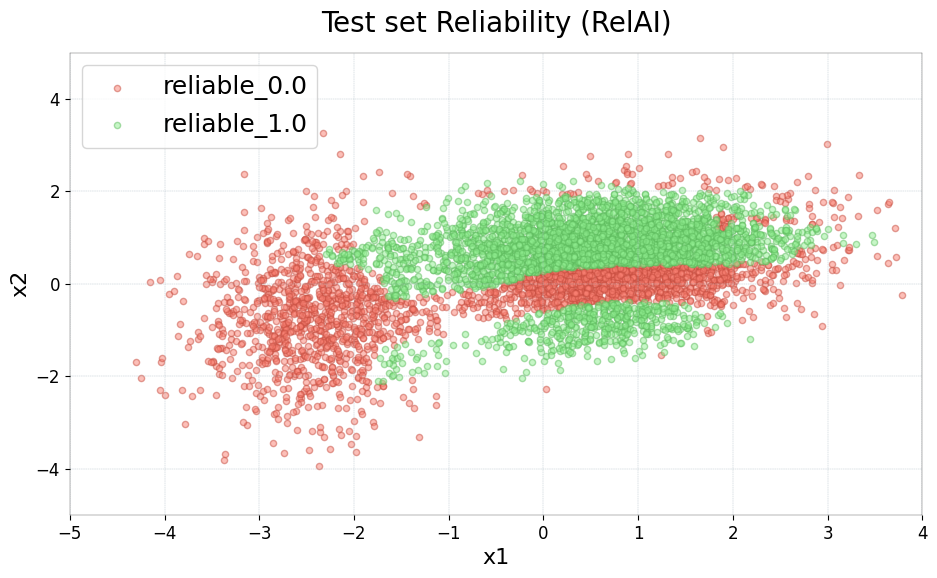

In [71]:
create_plot(p_df_test, colors = {0:'#fa8072', 1:'#90EE90'}, title='Test set Reliability (RelAI)',
            group_by='reliable', figsize=(11,6))

UNCERTAINTY BASED RELIABILITY

Reliability estimation based on the uncertainty as reported in "Aleatoric and Epistemic Uncertainty with Random Forests" (Mohammad Hossein Shaker1 and Eyke Hullermeier1). Implementation as reported on the github repository (https://github.com/GiovannaNicora/reliability) of "Evaluating pointwise reliability of machine learning prediction" (Nicora et al.)

In [39]:
def rf_total_uncertainty(clf, test_instance):
  """
  Input:
  - clf: trained model (RandomForestClassifier sklearn object)
  - single example to be classified (n.b. remember to .reshape(1,-1) the ndarray)
  """
  if isinstance(clf, RandomForestClassifier):
    ntrees = len(clf)
    nclasses = len(clf.classes_)
    unc = 0
    for c in range(nclasses):
      s = np.sum([clf[i].predict_proba(test_instance)[0, c] for i in range(ntrees)])/ntrees
      if s!=0:
        unc = unc-s*np.log2(s)


    return unc

def rf_aleatoric_uncertainty(clf, test_instance):
  """
  Input:
  - clf: trained model (RandomForestClassifier sklearn object)
  - single example to be classified (n.b. remember to .reshape(1,-1) the ndarray)
  """

  if isinstance(clf, RandomForestClassifier):
    ntrees = len(clf)
    nclasses = len(clf.classes_)
    unc = 0
    for t in range(ntrees):
      for c in range(nclasses):
        p = clf[t].predict_proba(test_instance)[0, c]
        if p!=0:
          unc = unc + p*np.log2(p)


    unc = -unc/ntrees
    return unc

Compute the epistemic, aleatoric, and total uncertainty of the test set

In [40]:
import scipy.stats as st
import seaborn as sns

# Calculate total, aleatoric and epistemic uncertainty
total_unc_test = []
aunc_test = [] # aleatoric uncertainty
for i in range(X_test.shape[0]):
  total_unc_test.append(rf_total_uncertainty(clf, X_test[i,:].reshape(1,-1)))

  aunc_test.append(rf_aleatoric_uncertainty(clf, X_test[i,:].reshape(1,-1)))

eunc_test = np.array(total_unc_test) - np.array(aunc_test)

Text(0.5, 1.0, 'Epistemic Uncertainty Test set')

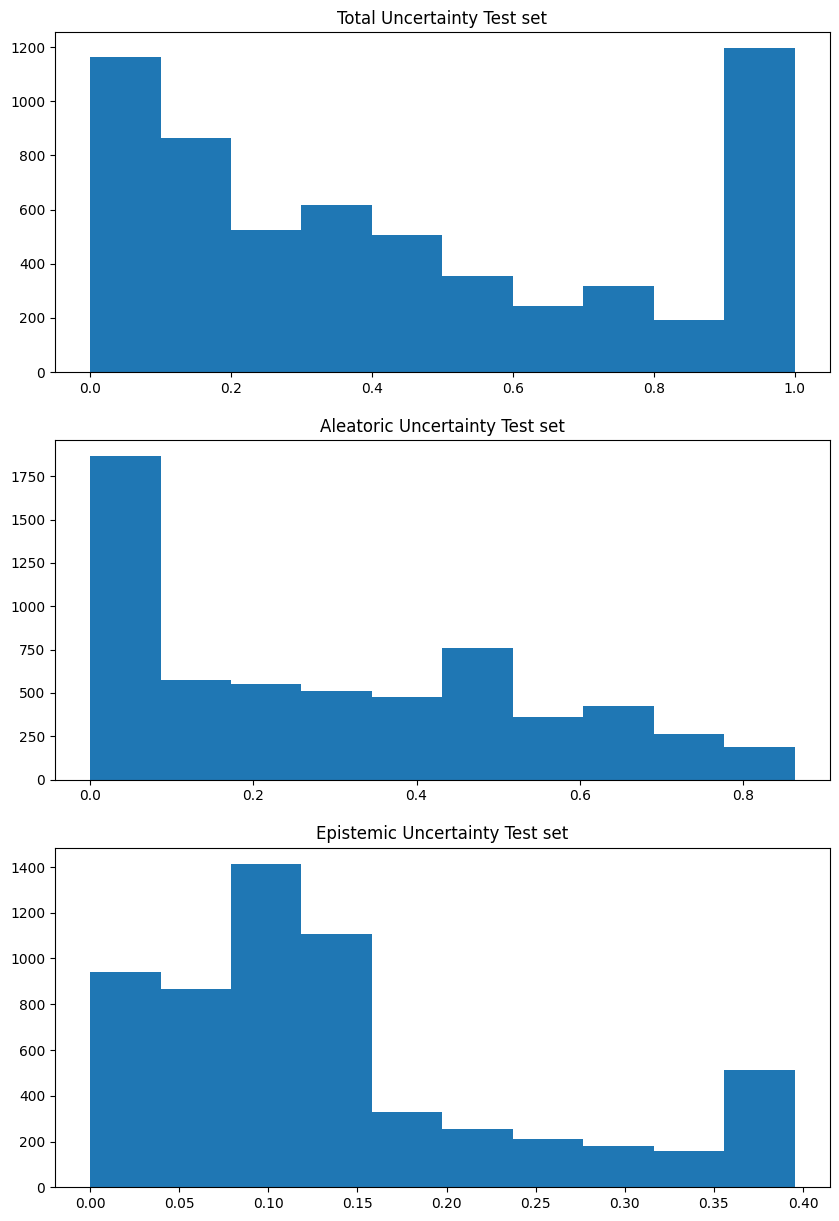

In [41]:
fig, ax = pyplot.subplots(figsize=(10,15), ncols=1, nrows=3)
ax[0].hist(total_unc_test)
ax[0].set_title('Total Uncertainty Test set')
ax[1].hist(aunc_test)
ax[1].set_title('Aleatoric Uncertainty Test set')
ax[2].hist(eunc_test)
ax[2].set_title('Epistemic Uncertainty Test set')

Uncertainty threshold as computed in (https://github.com/GiovannaNicora/reliability)

In [42]:
unc_threshold = 0.5555555555555556

Compute the reliability of the test set, based on the uncertainty of its samples with respect to the uncertainty threshold

In [43]:
unc_reliable_test = X_test[np.where(np.asarray(total_unc_test) < unc_threshold)]
unc_reliable_test_y = y_test[np.where(np.asarray(total_unc_test) < unc_threshold)]
unc_reliable_test_ypred = clf.predict(unc_reliable_test)
unc_unreliable_test = X_test[np.where(np.asarray(total_unc_test) > unc_threshold)]
unc_unreliable_test_y = y_test[np.where(np.asarray(total_unc_test) > unc_threshold)]
unc_unreliable_test_ypred = clf.predict(unc_unreliable_test)

In [44]:
print("Test set:")
print("Reliable:", unc_reliable_test.shape[0], "(",unc_reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", unc_unreliable_test.shape[0], "(",unc_unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")

Test set:
Reliable: 3906 ( 65.36144578313254 %)
Unreliable: 2070 ( 34.63855421686747 %)


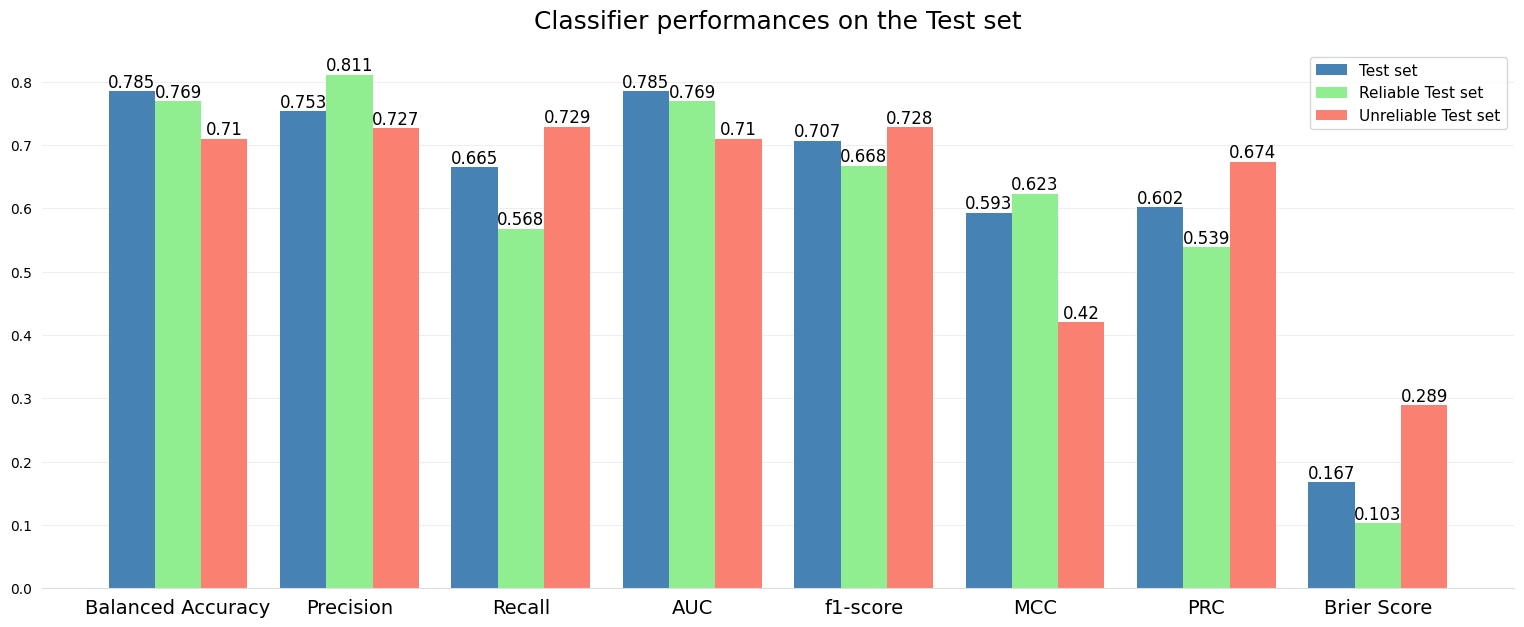

In [72]:
metrics_plots(y_test, ypred_test, unc_reliable_test_y, unc_reliable_test_ypred, unc_unreliable_test_y, unc_unreliable_test_ypred,'Test set')

DataFrame containing the labelled uncertainty-based reliable/unreliable instances of the Test set

In [64]:
unc_p_df_test_rel = pd.DataFrame(dict(x=unc_reliable_test[:,0], y=unc_reliable_test[:,1],reliable=np.ones(len(unc_reliable_test))))
unc_p_df_test_unrel = pd.DataFrame(dict(x=unc_unreliable_test[:,0], y=unc_unreliable_test[:,1],reliable=np.zeros(len(unc_unreliable_test))))
unc_p_df_test = pd.concat([unc_p_df_test_rel,unc_p_df_test_unrel])

Test set uncertainty-based reliability of the test set

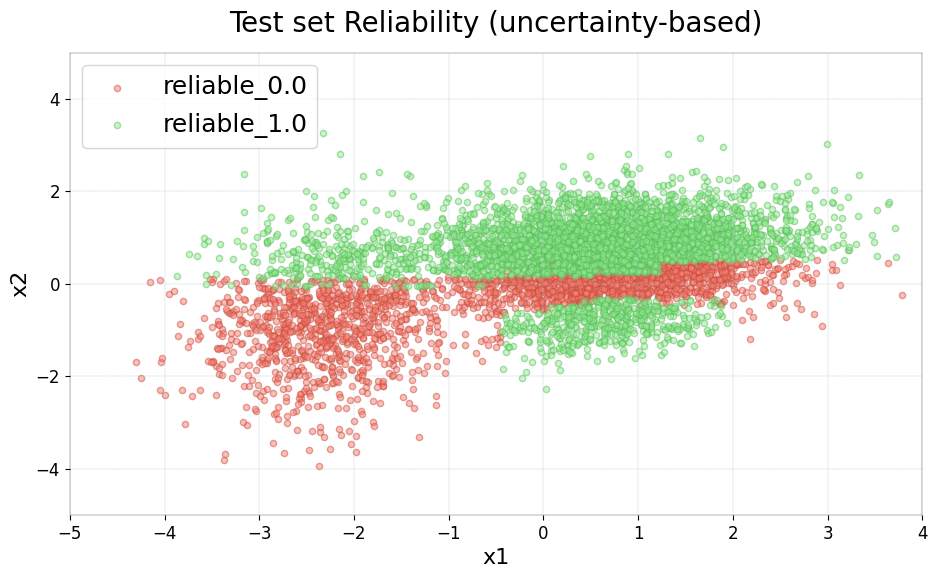

In [73]:
create_plot(unc_p_df_test, colors = {0:'#fa8072', 1:'#90EE90'}, title='Test set Reliability (uncertainty-based)',
            group_by='reliable', figsize=(11,6))

INSTANCE-BASED RELIABILITY

In [49]:
!cp "/content/drive/My Drive/prove_tesi_private/pop_implemetation.py" .

Density Principle

In [50]:
from pop_implemetation import pop_instance_training, check_is_border

# POP
(mind_train, maxd_train, isborder_train, attr2outerb_train, attr2innerb_train,
 attr2outerb_train_val, attr2innerb_train_val) = pop_instance_training(X_train_bal, y_train_bal)
train_border_examples = X_train_bal[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel(),:]
ytrain_border_examples = y_train_bal[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel()]

In [51]:
n_border_test = [0]*X_test.shape[0]
for c in list(range(X_test.shape[0])):
    #print(c)
    xtest = X_test[c]

    for i in range(X_test.shape[1]):
        bor = ''
        bor = bor + check_is_border(xtest[i], attr2outerb_train_val[i], inner=False)
        bor = bor + check_is_border(xtest[i], attr2innerb_train_val[i], inner=True)
        if 'Outer' in bor or 'Inner' in bor:
            n_border_test[c] = n_border_test[c]+1

In [52]:
#Density principle Reliability on the test set
pop_reliability_test_d = 1-np.array(n_border_test)/X_test.shape[1]
pop_unreliable_test_d_ix = np.argwhere(pop_reliability_test_d<1).ravel()
pop_reliable_test_d_ix = np.argwhere(pop_reliability_test_d==1).ravel() # or !=0

Local Fit Principle

In [53]:
from sklearn.metrics import accuracy_score

#Same number of neighbors used for the synthetic points-based method
k_pop = 5

#For each of the test samples, compute the accuracy of the nearest training samples
pop_acc_test = []

for i in range(len(X_test)):
  near_train_ex = []
  near_train_y = []
  distances = np.linalg.norm(X_train_bal - X_test[i], axis = 1)
  nn = distances.argsort()[:k_pop]
  pop_acc_test.append(accuracy_score(clf.predict(X_train_bal[nn,:]),y_train_bal[nn]))

pop_acc_test = np.asarray(pop_acc_test)

#Same accuracy theshold used for the synthetic points-based method
k_pop = 5
pop_loc_thresh = 0.85

pop_unreliable_test_lfp_ix = np.argwhere(pop_acc_test < pop_loc_thresh).ravel()
pop_reliable_test_lfp_ix = np.argwhere(pop_acc_test >= pop_loc_thresh).ravel()

In [54]:
#Combination of the reliable and unreliable indexes of the density and local fit principles
pop_reliable_test_ix = np.intersect1d(pop_reliable_test_lfp_ix,pop_reliable_test_d_ix)
pop_unreliable_test_ix = np.unique(np.concatenate([pop_unreliable_test_lfp_ix,pop_unreliable_test_d_ix]))

In [55]:
#POP-based Reliable and Unreliable test set
pop_reliable_test = X_test[pop_reliable_test_ix]
pop_reliable_test_y = y_test[pop_reliable_test_ix]
pop_reliable_test_ypred = clf.predict(pop_reliable_test)

pop_unreliable_test = X_test[pop_unreliable_test_ix]
pop_unreliable_test_y = y_test[pop_unreliable_test_ix]
pop_unreliable_test_ypred = clf.predict(pop_unreliable_test)

In [56]:
print("Test set:")
print("Reliable:", pop_reliable_test.shape[0], "(",pop_reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", pop_unreliable_test.shape[0], "(",pop_unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")

Test set:
Reliable: 3729 ( 62.399598393574294 %)
Unreliable: 2247 ( 37.600401606425706 %)


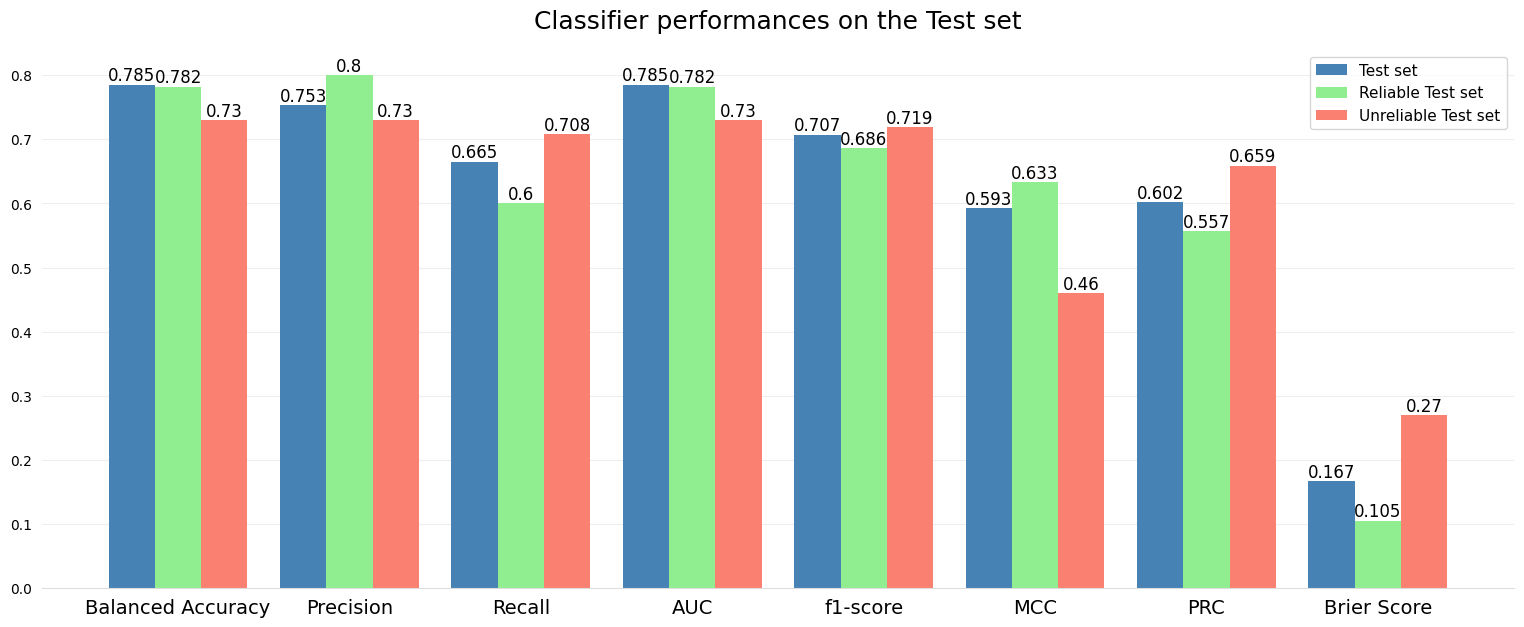

In [74]:
metrics_plots(y_test, ypred_test, pop_reliable_test_y, pop_reliable_test_ypred, pop_unreliable_test_y, pop_unreliable_test_ypred,'Test set')

DataFrame containing the labelled POP-based reliable/unreliable instances of the Test set

In [66]:
pop_p_df_test_rel = pd.DataFrame(dict(x=pop_reliable_test[:,0], y=pop_reliable_test[:,1],reliable=np.ones(len(pop_reliable_test))))
pop_p_df_test_unrel = pd.DataFrame(dict(x=pop_unreliable_test[:,0], y=pop_unreliable_test[:,1],reliable=np.zeros(len(pop_unreliable_test))))
pop_p_df_test = pd.concat([pop_p_df_test_rel,pop_p_df_test_unrel])

instance-based reliability of the test set

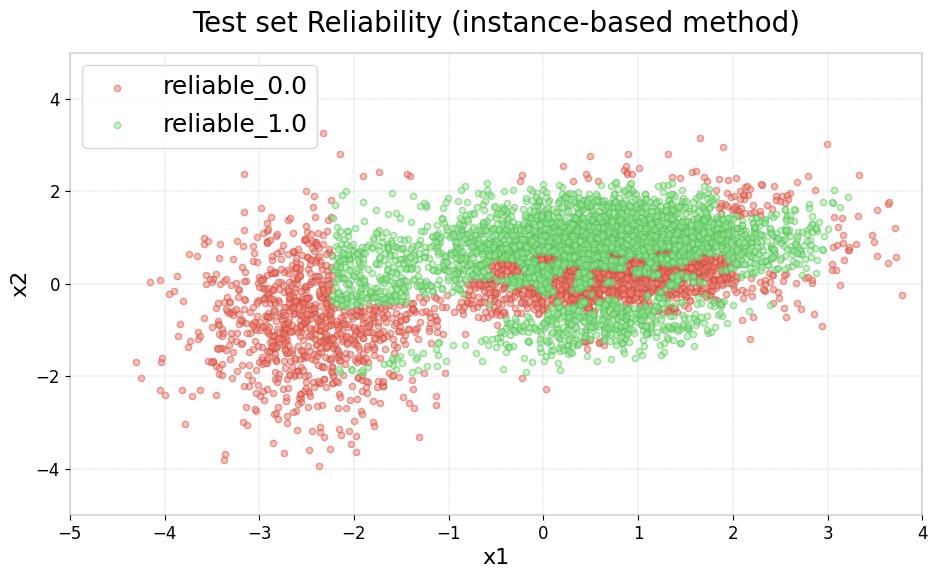

In [75]:
create_plot(pop_p_df_test, colors = {0:'#fa8072', 1:'#90EE90'}, title='Test set Reliability (instance-based method)',
            group_by='reliable', figsize=(11,6))